In [1]:
import glob
import os
import itertools
from itertools import islice

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
import pickle
import tensorflow as tf
import pandas as pd

2024-12-08 12:51:09.604756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 12:51:09.787630: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 12:51:09.790981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import MobileNetV2, DenseNet169
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization, LSTM, GlobalAveragePooling2D, TimeDistributed, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal, GlorotUniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.data import AUTOTUNE
from tensorflow.keras import regularizers
from sklearn.preprocessing import LabelEncoder

In [3]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras import layers, models

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [1]:
import os
project_dir = os.path.join('materials', 'ISIC-2024_CS640')
os.listdir(project_dir)

['test_metadata.csv',
 'fhjcfv.txt',
 'submission.csv',
 '.ipynb_checkpoints',
 'train_metadata.csv',
 'train_image',
 'test_image']

In [6]:
df_train = pd.read_csv(os.path.join(project_dir, "train_metadata.csv"))
y = df_train[['id', 'target']]
y

,id,target
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
320842,320842,0
320843,320843,0
320844,320844,0
320845,320845,0


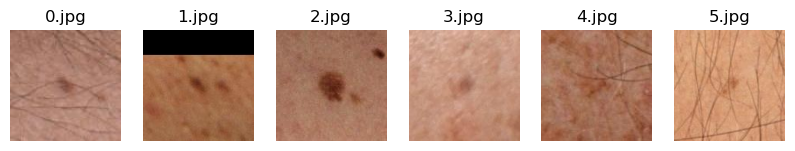

In [7]:
fig, axes = plt.subplots(1, 6, figsize = (10, 20))
for i in range(6):
    id = str(df_train["id"][i])
    image = img.imread(os.path.join(project_dir, "train_image", id + ".jpg"))
    axes[i].imshow(image)
    axes[i].set_title(id + ".jpg")
    axes[i].set_axis_off()
plt.show()

In [8]:
TRAIN_PATH = os.path.join(project_dir, 'train_image')
data_df = pd.read_csv(os.path.join(project_dir, "train_metadata.csv"))
data_df['target'] = data_df['target'].astype(np.int32)
data_df['filename'] = data_df['id'].apply(lambda x: os.path.join(TRAIN_PATH, f"{x}.jpg"))
data_df = data_df[['filename', 'target']]
df1 = data_df[data_df['target'] == 0][:100000]
# print(df1.head())
df2 = data_df[data_df['target'] == 1][:250] #minority
df_combined = pd.concat([df1, df2], ignore_index=True)
data_df = df_combined

In [9]:
# Load Images and Labels
def load_image_and_label(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE) / 255.0  # Normalize
    label = tf.cast(label, tf.int32)
    return img, label

# Create TensorFlow Dataset
def create_dataset(df, shuffle=True):
    file_paths = df['filename'].values
    labels = df['target'].values.astype(np.int32)
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(
        lambda x, y: load_image_and_label(x, y), 
        num_parallel_calls=AUTOTUNE
    )
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    return dataset

In [10]:
from PIL import Image

# Initialize ImageDataGenerator with augmentation parameters
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a function to augment images and append to the dataset
def augment_minority_class(data_df, minority_label, output_dir, num_copies=5):
    """
    Augments images from the minority class and appends augmented images to the dataset.

    Args:
        data_df (pd.DataFrame): DataFrame containing 'filename' and 'target' columns.
        minority_label (str or int): Label of the minority class.
        output_dir (str): Directory to store augmented images temporarily.
        num_copies (int): Number of augmented copies to generate per image.

    Returns:
        pd.DataFrame: Updated DataFrame with augmented images.
    """
    # Filter the minority class images
    minority_images = data_df[data_df['target'] == minority_label]

    # To store new data
    augmented_data = []

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Process each image
    for idx, row in minority_images.iterrows():
        img_path = row['filename']
        target_label = row['target']

        # Load and preprocess the image
        img = tf.keras.preprocessing.image.load_img(img_path)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)  # Add batch dimension

        # Generate augmented images
        gen = data_gen.flow(img_array, batch_size=1)
        for _ in range(num_copies):
            batch = next(gen)
            augmented_img_array = batch[0].astype('uint8')
            augmented_image_path = os.path.join(output_dir, f"aug_{idx}_{_}.jpeg")
            Image.fromarray(augmented_img_array).save(augmented_image_path)
            # Append the augmented image path and label
            augmented_data.append({'filename': augmented_image_path, 'target': target_label})

    # Convert augmented data to DataFrame
    augmented_df = pd.DataFrame(augmented_data)
    augmented_df['target'] = augmented_df['target'].astype(np.int32)
    # Combine original data with augmented data
    return augmented_df 

# Example Usage
# Assuming `data_df` is your original dataset with columns 'filename' and 'target'
output_directory = 'augmented_images'  # Directory to store augmented images
minority_class_label = 1  # Label of the minority class
aug_df = augment_minority_class(data_df, minority_class_label, output_directory, num_copies=7)
data_df_aug = pd.concat([data_df, aug_df], ignore_index=True)
data_df_aug['target'] = data_df_aug['target'].astype(np.int32)
print(aug_df.head())




# Initialize a LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the target column to integers
data_df_aug['target'] = label_encoder.fit_transform(data_df_aug['target'])

# Save the mapping for later use
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

                             filename  target
0  augmented_images/aug_100000_0.jpeg       1
1  augmented_images/aug_100000_1.jpeg       1
2  augmented_images/aug_100000_2.jpeg       1
3  augmented_images/aug_100000_3.jpeg       1
4  augmented_images/aug_100000_4.jpeg       1
Label Mapping: {0: 0, 1: 1}


In [11]:
# Split the dataset
# Set Parameters
IMG_SIZE = (299, 299)  # EfficientNetB3's default input size
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE

train_df, val_df = train_test_split(
    data_df_aug, 
    test_size=0.2, 
    stratify=data_df_aug['target'], 
    random_state=42
)

# Create TensorFlow datasets for training and validation
train_dataset = create_dataset(train_df, shuffle=True)
val_dataset = create_dataset(val_df, shuffle=False)


def cast_to_required_types(image, label):
    # Cast image to float32 and label to int32
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

# Apply the casting function to the dataset
train_dataset = train_dataset.map(cast_to_required_types)
val_dataset = val_dataset.map(cast_to_required_types)


for image, label in val_dataset.take(5):
    print("Image dtype:", image.dtype)
    print("Label dtype:", label.dtype)

print("Dataset structure:", train_dataset.element_spec)

Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>
Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>
Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>
Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>
Image dtype: <dtype: 'float32'>
Label dtype: <dtype: 'int32'>
Dataset structure: (TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [12]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),  # Assuming two classes: 0 and 1
    y=data_df_aug['target'].astype(np.int32)
)
class_weights = class_weights.astype(np.float32)
# Convert class weights to a dictionary for Keras
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.51, 1: 25.5}


In [13]:
from tqdm import tqdm

class TQDMProgressBar(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epochs = self.params['epochs']
        self.epochs_bar = tqdm(total=self.epochs, desc="Epoch Progress", position=0, leave=True)

    def on_batch_end(self, batch, logs=None):
        # Update progress bar after each batch
        self.epochs_bar.set_postfix(logs)
        self.epochs_bar.update(1)
        
    def on_epoch_end(self, epoch, logs=None):
        self.epochs_bar.set_postfix(logs)
        self.epochs_bar.update(1)

# Instantiate the tqdm progress bar callback
progress_bar = TQDMProgressBar()

In [14]:

# Define custom callback for saving model, weights, and history
class SaveModelHistoryCallback(Callback):
    def __init__(self, save_path, save_interval=4):
        super().__init__()
        self.save_path = save_path
        self.save_interval = save_interval
        if not os.path.exists(self.save_path):
            os.makedirs(self.save_path)

    def on_epoch_end(self, epoch, logs=None):
        # Save the model, weights, and history after every `save_interval` epochs
        if (epoch + 1) % self.save_interval == 0:
            # Save model weights
            weights_path = os.path.join(self.save_path, f"model_weights_epoch_{epoch + 1}.weights.h5")
            self.model.save_weights(weights_path)
            print(f"Saved weights at: {weights_path}")

            # Save the entire model
            model_path = os.path.join(self.save_path, f"model_epoch_{epoch + 1}.h5")
            self.model.save(model_path)
            print(f"Saved model at: {model_path}")

            # Save training history
            history_path = os.path.join(self.save_path, f"history_epoch_{epoch + 1}.pkl")
            with open(history_path, "wb") as history_file:
                pickle.dump(self.model.history.history, history_file)
            print(f"Saved history at: {history_path}")


In [48]:
# Load the InceptionResNetV2 model pre-trained on ImageNet without the top layer
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model to prevent updating the pre-trained weights during training
# base_model.trainable = False
# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
# ])

base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze the first N layers
    layer.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.03))
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(dtype='int32'), tf.keras.metrics.Recall(dtype='int32')]
)

if not os.path.isdir('./Training_Results/'):
    os.mkdir('./Training_Results/')

# callbacks creation
if not os.path.isdir('./Training_Results/saved_models/'):
    os.mkdir('./Training_Results/saved_models/')

# save the best model each time
path = './Training_Results/saved_models/'
# Instantiate the custom callback
save_callback = SaveModelHistoryCallback(save_path=path, save_interval=3)

# start training
print('\nStart training . . .')

# Train the model using the data generator
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=12,  # Change the number of epochs as needed
    verbose=0,
    class_weight=class_weights_dict,
    callbacks=[progress_bar, save_callback]
)
# history = model.fit(
#     train_dataset,
#     validation_data=val_dataset,
#     epochs=3,  # Change the number of epochs as needed
#     callbacks=[progress_bar]
# )
model.save_weights('./Training_Results/saved_models/model_VGG16_V9.weights.h5')


Start training . . .


Epoch Progress: 20401it [05:34, 60.95it/s, accuracy=0.92, loss=0.346, precision_5=0.177, recall_5=0.846, val_accuracy=0.953, val_loss=0.253, val_precision_5=0.281, val_recall_5=0.9]
Epoch Progress: 20401it [05:14, 64.96it/s, accuracy=0.951, loss=0.255, precision_5=0.268, recall_5=0.872, val_accuracy=0.981, val_loss=0.148, val_precision_5=0.509, val_recall_5=0.88]
Epoch Progress: 20401it [05:13,  1.86s/it, accuracy=0.958, loss=0.226, precision_5=0.304, recall_5=0.901, val_accuracy=0.982, val_loss=0.096, val_precision_5=0.526, val_recall_5=0.895]WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


Saved weights at: ./Training_Results/saved_models/model_weights_epoch_3.weights.h5
Saved model at: ./Training_Results/saved_models/model_epoch_3.h5
Saved history at: ./Training_Results/saved_models/history_epoch_3.pkl


Epoch Progress: 20401it [05:14, 64.78it/s, accuracy=0.958, loss=0.226, precision_5=0.304, recall_5=0.901, val_accuracy=0.982, val_loss=0.096, val_precision_5=0.526, val_recall_5=0.895]
Epoch Progress: 20401it [05:12, 65.30it/s, accuracy=0.966, loss=0.192, precision_5=0.359, recall_5=0.908, val_accuracy=0.993, val_loss=0.0862, val_precision_5=0.806, val_recall_5=0.86]
Epoch Progress: 20401it [05:04, 67.08it/s, accuracy=0.968, loss=0.175, precision_5=0.369, recall_5=0.915, val_accuracy=0.958, val_loss=0.186, val_precision_5=0.309, val_recall_5=0.902]
Epoch Progress: 20401it [05:01,  1.89s/it, accuracy=0.97, loss=0.154, precision_5=0.389, recall_5=0.928, val_accuracy=0.985, val_loss=0.0965, val_precision_5=0.568, val_recall_5=0.882]WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_m

Saved weights at: ./Training_Results/saved_models/model_weights_epoch_6.weights.h5
Saved model at: ./Training_Results/saved_models/model_epoch_6.h5
Saved history at: ./Training_Results/saved_models/history_epoch_6.pkl


Epoch Progress: 20401it [05:02, 67.39it/s, accuracy=0.97, loss=0.154, precision_5=0.389, recall_5=0.928, val_accuracy=0.985, val_loss=0.0965, val_precision_5=0.568, val_recall_5=0.882]
Epoch Progress: 20401it [05:02, 67.49it/s, accuracy=0.971, loss=0.137, precision_5=0.399, recall_5=0.943, val_accuracy=0.934, val_loss=0.197, val_precision_5=0.222, val_recall_5=0.945]
Epoch Progress: 17881it [03:37, 82.44it/s, accuracy=0.975, loss=0.126, precision_5=0.437, recall_5=0.952]                 IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch Progress: 20401it [04:59, 68.12it/s, accuracy=0.975, loss=0.124, precision_5=0.437, recall_5=0.953, val_accuracy=0.984, val_loss=0.0789, val_precision_5=0.565, val_recall_5=0.887]
Epoc

Saved weights at: ./Training_Results/saved_models/model_weights_epoch_9.weights.h5
Saved model at: ./Training_Results/saved_models/model_epoch_9.h5
Saved history at: ./Training_Results/saved_models/history_epoch_9.pkl


Epoch Progress: 20401it [05:00, 67.87it/s, accuracy=0.976, loss=0.113, precision_5=0.444, recall_5=0.957, val_accuracy=0.969, val_loss=0.114, val_precision_5=0.383, val_recall_5=0.918]
Epoch Progress: 14619it [02:58, 83.95it/s, accuracy=0.982, loss=0.0876, precision_5=0.514, recall_5=0.973]         IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch Progress: 20401it [05:00, 67.99it/s, accuracy=0.979, loss=0.093, precision_5=0.485, recall_5=0.969, val_accuracy=0.978, val_loss=0.111, val_precision_5=0.469, val_recall_5=0.918]
Epoch Progress: 11316it [02:18, 84.57it/s, accuracy=0.982, loss=0.0878, precision_5=0.531, recall_5=0.976]         IOPub message rate exceeded.
The Jupyter server will temporarily stop sending outp

Saved weights at: ./Training_Results/saved_models/model_weights_epoch_12.weights.h5
Saved model at: ./Training_Results/saved_models/model_epoch_12.h5
Saved history at: ./Training_Results/saved_models/history_epoch_12.pkl


In [49]:
# history_path = "./Training_Results/saved_models/history_epoch_16.pkl"

# # Load the history
# with open(history_path, "rb") as f:
#     history_data = pickle.load(f)

# # Print validation accuracy for each epoch
# if "val_accuracy" in history_data:
#     print("Epoch-wise Validation Accuracy:")
#     for epoch, val_acc in enumerate(history_data["val_accuracy"], start=1):
#         print(f"Epoch {epoch}: {val_acc:.4f}")
# else:
#     print("Validation accuracy not found in the saved history. Ensure your model was compiled with 'accuracy' as a metric.")


In [15]:
TRAIN_PATH = os.path.join(project_dir, 'train_image')
data_df = pd.read_csv(os.path.join(project_dir, "train_metadata.csv"))
data_df['target'] = data_df['target'].astype(np.int32)
data_df['filename'] = data_df['id'].apply(lambda x: os.path.join(TRAIN_PATH, f"{x}.jpg"))
data_df = data_df[['filename', 'target']]
df2 = data_df[data_df['target'] == 1][251:] #minority
df1 = data_df[data_df['target'] == 0][100001:100001 + len(df2)]
# print(df1.head())

df_combined = pd.concat([df1, df2], ignore_index=True)
data_df = df_combined

label_encoder = LabelEncoder()

# Fit and transform the target column to integers
data_df['target'] = label_encoder.fit_transform(data_df['target'])

# Save the mapping for later use
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

# Split the dataset
# Set Parameters
IMG_SIZE = (299, 299) 
BATCH_SIZE = 1
AUTOTUNE = tf.data.AUTOTUNE


test_dataset = create_dataset(data_df, shuffle=True)

Label Mapping: {0: 0, 1: 1}


In [17]:
# Load the InceptionResNetV2 model pre-trained on ImageNet without the top layer
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model to prevent updating the pre-trained weights during training
# base_model.trainable = False
# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))
# ])

base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze the first N layers
    layer.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.03))
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(dtype='int32'), tf.keras.metrics.Recall(dtype='int32')]
)
model.build((None, 299, 299, 3)) 
model.load_weights('./Training_Results/saved_models/model_VGG16_V9.weights.h5')

/share/pkg.8/academic-ml/fall-2024/install/fall-2024-tf/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


I0000 00:00:1733680375.213363  377943 service.cc:146] XLA service 0x14faa40031e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733680375.213396  377943 service.cc:154]   StreamExecutor device (0): NVIDIA L40S, Compute Capability 8.9


  14/5100 ━━━━━━━━━━━━━━━━━━━━ 42s 8ms/step  

I0000 00:00:1733680379.265812  377943 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5100/5100 ━━━━━━━━━━━━━━━━━━━━ 47s 8ms/step


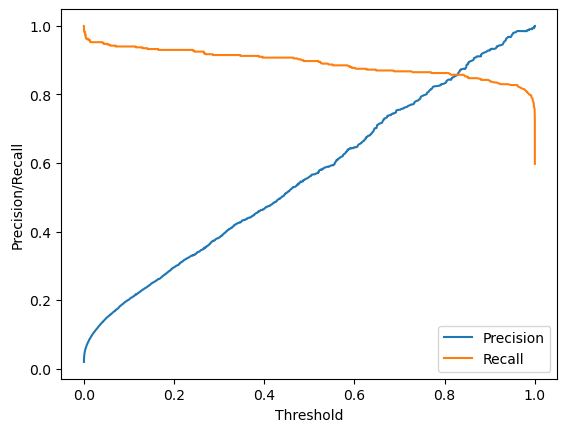

In [18]:
#VALidation

from sklearn.metrics import precision_recall_curve
y_true_val = []
for _, labels in val_dataset:
    y_true_val.extend(labels.numpy())
y_true_val = np.array(y_true_val)
# Predict probabilities
y_probs_val = model.predict(val_dataset)

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true_val, y_probs_val)

# Plot the precision-recall tradeoff
import matplotlib.pyplot as plt
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [19]:
custom_threshold = 0.9
y_preds_val = (y_probs_val >= custom_threshold).astype(int)

# Evaluate metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true_val, y_preds_val)
recall = recall_score(y_true_val, y_preds_val)
f1 = f1_score(y_true_val, y_preds_val)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Precision: 0.9307479224376731
Recall: 0.84
F1-Score: 0.8830486202365309


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


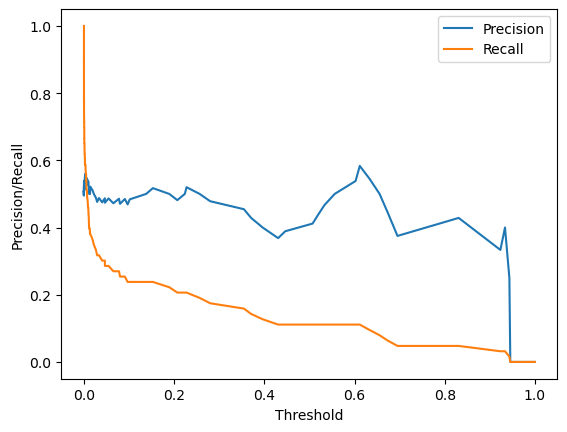

In [20]:
###  TEST

# Extract true labels
y_true_test = []
for _, labels in test_dataset:
    y_true_test.extend(labels.numpy())
y_true_test = np.array(y_true_test)

# Get predicted probabilities
y_probs_test = model.predict(test_dataset)

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true_test, y_probs_test)

# Plot the precision-recall tradeoff
import matplotlib.pyplot as plt
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [37]:
# Apply custom threshold
custom_threshold = 0.06
y_preds_test = (y_probs_test >= custom_threshold).astype(int)

# Evaluate metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true_test, y_preds_test)
recall = recall_score(y_true_test, y_preds_test)
f1 = f1_score(y_true_test, y_preds_test)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Precision: 0.5737704918032787
Recall: 0.5555555555555556
F1-Score: 0.5645161290322581


In [35]:
test_loss, test_acc, precision, recall= model.evaluate(test_dataset)
f1 = 2 * precision * recall / (precision + recall)
print(f1)

126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5873 - loss: 1.0735 - precision_4: 0.6457 - recall_4: 0.0820
0.27397261084322855


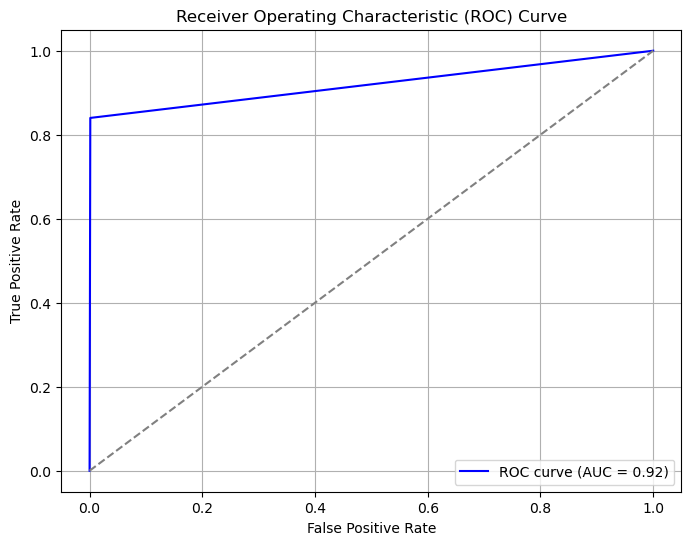

In [21]:
from sklearn.metrics import roc_curve, auc

# Assuming you have your true labels and model predictions
# Example:
# true_labels = your_test_labels  # e.g., a NumPy array or a Tensor of true labels (0 or 1)
# predicted_probs = model.predict(your_test_data)  # Model predictions (probabilities)

# If you're using binary classification:
# predicted_probs is an array of shape (n_samples,) with probability scores for the positive class (e.g., class 1)

# Compute ROC curve

fpr, tpr, thresholds = roc_curve(y_true_val, y_preds_val)

# Compute AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [58]:
print(true_labels)

[1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0]
